# Property regression example

## low level interface

To show how the components of NFFLr work together, let's train a formation energy model using the `dft_3d` dataset.
We can use the `periodic_radius_graph` transform to configure the `AtomsDataset` to automatically transform atomic configurations into `DGLGraph`s.

In [9]:
import nfflr

transform = nfflr.nn.PeriodicRadiusGraph(cutoff=5.0)

dataset = nfflr.AtomsDataset(
    "dft_3d", 
    target="formation_energy_peratom", 
    transform=transform,
)
dataset[0]

dataset_name='dft_3d'
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


(Graph(num_nodes=8, num_edges=288,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(-0.4276))

In [10]:
dataset = nfflr.AtomsDataset(
    "/Users/bld/projects/nfflr/examples/poscar-folder-bandgap", 
    target="target", 
    transform=transform,
)
dataset[0]

dataset_name='/Users/bld/projects/nfflr/examples/poscar-folder-bandgap'


(Graph(num_nodes=8, num_edges=288,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(0.))

Set up a medium-sized ALIGNN model:

In [4]:
atoms

Graph(num_nodes=8, num_edges=1248,
      ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)})

In [11]:
cfg = nfflr.models.ALIGNNConfig(
    transform=transform,
    alignn_layers=2, 
    gcn_layers=2, 
    norm="layernorm", 
    atom_features="embedding"
)
model = nfflr.models.ALIGNN(cfg)

atoms, target = dataset[0]
model(atoms)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor(-1.1278, grad_fn=<SqueezeBackward0>)

In [12]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler

batchsize = 2

train_loader = DataLoader(
    dataset,
    batch_size=batchsize, 
    collate_fn=dataset.collate, 
    sampler=SubsetRandomSampler(dataset.split["train"]),
    drop_last=True
)
next(iter(train_loader))

(Graph(num_nodes=34, num_edges=1162,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor([0., 0.]))

Now we can set up a PyTorch optimizer and objective function and optimize the model parameters with an explicit training loop. See the [PyTorch quickstart tutorial for more context)[https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html].

In [13]:
from tqdm import tqdm
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)

training_loss = []
for epoch in range(5):
    for step, (g, y) in enumerate(tqdm(train_loader)):
        pred = model(g)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        training_loss.append(loss.item())

100%|██████████| 19/19 [00:04<00:00,  3.90it/s]


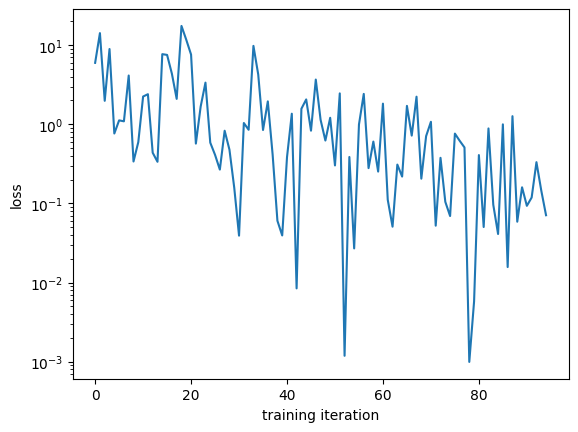

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_loss)
plt.xlabel("training iteration")
plt.ylabel("loss");
plt.semilogy();

# using the ignite-based NFFLr trainer

In [15]:
import tempfile
from nfflr import train

In [17]:
rank = 0
training_config = {
    "dataset": dataset,
    "model": model,
    "optimizer": optimizer,
    "criterion": criterion,
    "random_seed": 42,
    "batch_size": 2,
    "learning_rate": 1e-3,
    "weight_decay": 0.1,
    "epochs": 5,
    "num_workers": 0,
    "progress": True,
    "output_dir": tempfile.TemporaryDirectory().name
}
train.run_train(rank, training_config)

2024-01-19 09:39:01,426 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<nfflr.data.dataset.': 
	{'collate_fn': <function AtomsDataset.collate_default at 0x296db64d0>, 'batch_size': 2, 'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x67e2de410>, 'drop_last': True, 'num_workers': 0, 'pin_memory': False}
2024-01-19 09:39:01,426 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<nfflr.data.dataset.': 
	{'collate_fn': <function AtomsDataset.collate_default at 0x296db64d0>, 'batch_size': 2, 'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x67d998dc0>, 'drop_last': True, 'num_workers': 0, 'pin_memory': False}


starting training loop


/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 1  Avg loss: 0.00


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 1  Avg loss: 3.89


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 2  Avg loss: 0.10


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 2  Avg loss: 3.95


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 3  Avg loss: 0.11


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 3  Avg loss: 1.36


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 4  Avg loss: 0.03


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 4  Avg loss: 4.02


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 5  Avg loss: 0.01


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 5  Avg loss: 3.94


3.9357571601867676